# **Task 5 - Movie Recommendation System**
- To design a recommendation system that suggests movies based on user similarity.
- To implement collaborative filtering techniques (user-based, item-based).
- To explore matrix factorization (SVD) for scalable and personalized recommendations.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Machine learning/20CS36/movies dataset/ml-100k/"

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split


# **Load the Dataset**

We use the MovieLens 100K dataset.

***ratings*** → contains user ratings for movies

***movies*** → contains movie metadata (movie_id, title, etc.)


### **Ratings**

*   the main input for collaborative filtering.

### **Movies metadata**

*   for displaying recommendations with movie names.





In [22]:
ratings = pd.read_csv(path +"u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv(path +"u.item", sep="|", encoding="latin-1", header=None,
                     names=["movie_id", "title", "release_date", "video_release", "IMDb_URL", "unknown",
                            "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary",
                            "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                            "Thriller", "War", "Western"])

In [23]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
movies.head()

,movie_id,title,release_date,video_release,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Keep only necessary columns
ratings = ratings[["user_id", "movie_id", "rating"]]
movies = movies[["movie_id", "title"]]


In [26]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [27]:
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


# **Train-Test Split**

We split ratings into train (80%) and test (20%).

***Train*** = used to build the recommender

***Test*** = used to evaluate recommendations

We need to hide some ratings during training to check if the model can recover them → this ensures meaningful evaluation.

In [29]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)


# **User-Item Matrix**

We create a matrix of users vs movies.

Rows = users

Columns = movies

Values = ratings

In [30]:
train_matrix = train.pivot_table(index="user_id", columns="movie_id", values="rating").fillna(0)


This matrix is the foundation of collaborative filtering. Each row is a user profile, each column is a movie profile.

In [32]:
train_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.0,4.0,0.0,3.0,0.0,4.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **User Similarity**

We compute cosine similarity between users.

Similar users are those who rated movies similarly.

In [33]:
user_similarity = cosine_similarity(train_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)


If two users rated movies in similar ways, they probably like similar content → we can recommend movies from one to the other.

In [34]:
user_similarity_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.136196,0.030424,0.026203,0.284613,0.331412,0.319056,0.274139,0.083486,0.281396,...,0.277459,0.084849,0.205849,0.144161,0.133679,0.092367,0.216948,0.084181,0.104599,0.329288
2,0.136196,1.000000,0.114644,0.168220,0.093128,0.162165,0.095848,0.091360,0.149476,0.125701,...,0.149359,0.268977,0.320095,0.323347,0.241012,0.152655,0.230951,0.117484,0.166632,0.096719
3,0.030424,0.114644,1.000000,0.346894,0.000000,0.085071,0.032829,0.053875,0.060177,0.052552,...,0.021713,0.017707,0.154299,0.049358,0.107604,0.019022,0.101207,0.021959,0.127179,0.013805
4,0.026203,0.168220,0.346894,1.000000,0.011848,0.051287,0.075209,0.142100,0.060465,0.035202,...,0.034908,0.044480,0.087428,0.118082,0.100612,0.000000,0.151086,0.110324,0.112342,0.032367
5,0.284613,0.093128,0.000000,0.011848,1.000000,0.168527,0.298438,0.185290,0.039737,0.166013,...,0.276012,0.103529,0.085547,0.072429,0.104445,0.049198,0.204472,0.148028,0.099978,0.247527


# **Recommendation Function (User-Based CF)**

We recommend movies for a target user:

1.   Find most similar users
2.   Take their ratings
3.   Average them to predict ratings for the target user
4.   Exclude movies the user already rated
5.   Return top-N recomendations







In [35]:
def recommend_movies_train(user_id, k=5, top_n=5):
    if user_id not in train_matrix.index:
        return pd.DataFrame(columns=["movie_id", "Predicted Rating"])  # handle missing user

    # Step 1: find similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:k+1]

    # Step 2: ratings from similar users
    similar_users_ratings = train_matrix.loc[similar_users]

    # Step 3: average ratings
    avg_ratings = similar_users_ratings.mean(axis=0)

    # Step 4: remove movies user has already rated
    user_rated = train_matrix.loc[user_id]
    unseen_movies = avg_ratings[user_rated == 0]

    # Step 5: pick top-N
    top_recommendations = unseen_movies.sort_values(ascending=False).head(top_n)
    top_recommendations = top_recommendations.rename("Predicted Rating")

    return movies[movies["movie_id"].isin(top_recommendations.index)].merge(
        top_recommendations, left_on="movie_id", right_index=True)


This is the heart of user-based collaborative filtering: recommend based on what similar users liked.

# **Evaluation Metrics**

## **Precision@K**

1.   Measures how many of the top-K recommended movies are relevant.
2.   High precision = recommendations are accurate.


In [36]:
def precision_at_k(user_id, k=5, threshold=3.5):
    recommended = recommend_movies_train(user_id, k=k, top_n=k)

    actual = test[(test["user_id"] == user_id) &
                  (test["movie_id"].isin(recommended["movie_id"]))]

    if actual.empty:
        return None

    relevant = (actual["rating"] >= threshold).astype(int)
    recommended_relevant = np.ones(len(actual))

    return precision_score(relevant, recommended_relevant, zero_division=0)


## **Recall@K**


1.   Measures how many of the user’s relevant movies were captured in top-K.
2.   High recall = system covers more of what the user likes.





In [37]:
def recall_at_k(user_id, k=5, threshold=3.5):
    recommended = recommend_movies_train(user_id, k=k, top_n=k)

    actual = test[(test["user_id"] == user_id) &
                  (test["movie_id"].isin(recommended["movie_id"]))]

    all_relevant = test[(test["user_id"] == user_id) & (test["rating"] >= threshold)]

    if all_relevant.empty:
        return None

    relevant = (actual["rating"] >= threshold).sum()
    return relevant / len(all_relevant)


## **F1@K**

1.   Combines precision and recall.





In [38]:
def f1_at_k(user_id, k=5, threshold=3.5):
    p = precision_at_k(user_id, k=k, threshold=threshold)
    r = recall_at_k(user_id, k=k, threshold=threshold)
    if p is None or r is None or (p + r) == 0:
        return None
    return 2 * (p * r) / (p + r)


# **Test Example Users**

In [40]:
print("Precision@5 for User 1:", precision_at_k(1, k=5))
print("Recall@5 for User 1:", recall_at_k(1, k=5))
print("F1@5 for User 1:", f1_at_k(1, k=5))



Precision@5 for User 1: 0.3333333333333333
Recall@5 for User 1: 0.029411764705882353
F1@5 for User 1: 0.05405405405405406


In [41]:
print("Precision@5 for User 10:", precision_at_k(10, k=5))
print("Recall@5 for User 10:", recall_at_k(10, k=5))
print("F1@5 for User 10:", f1_at_k(10, k=5))


Precision@5 for User 10: 1.0
Recall@5 for User 10: 0.07692307692307693
F1@5 for User 10: 0.14285714285714288


# **Average Metrics Across All Users**

In [43]:
precisions = [precision_at_k(u, k=5) for u in test["user_id"].unique()]
recalls = [recall_at_k(u, k=5) for u in test["user_id"].unique()]
f1s = [f1_at_k(u, k=5) for u in test["user_id"].unique()]

precisions = [p for p in precisions if p is not None]
recalls = [r for r in recalls if r is not None]
f1s = [f for f in f1s if f is not None]

print("Average Precision@5:", np.mean(precisions))
print("Average Recall@5:", np.mean(recalls))
print("Average F1@5:", np.mean(f1s))


Average Precision@5: 0.7536147501213004
Average Recall@5: 0.1321469779222263
Average F1@5: 0.2951993893446654


# **Bonus**

# **Item-Based Collaborative Filtering (Item-CF)**

## **Idea:**



1.   Instead of finding similar users, we find similar movies.
2.   If a user liked Movie A, recommend movies similar to Movie A.





# **Compute Item Similarity**

We use cosine similarity on the transpose of user-item matrix.

Two movies are similar if they are rated similarly by many users.

In [44]:
# Compute item-item similarity (movies compared to movies)
item_similarity = cosine_similarity(train_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=train_matrix.columns,
                                  columns=train_matrix.columns)


# **Recommendation Function (Item-CF)**

This uses movie similarity to recommend items instead of relying only on similar users.

In [45]:
def recommend_movies_item(user_id, top_n=5):
    if user_id not in train_matrix.index:
        return pd.DataFrame(columns=["movie_id", "Predicted Rating"])  # handle missing user

    # Get the user's ratings
    user_ratings = train_matrix.loc[user_id]

    # Weighted sum of item similarities
    scores = np.dot(user_ratings, item_similarity_df)

    # Convert to Series
    scores = pd.Series(scores, index=item_similarity_df.columns)

    # Remove movies already rated
    scores[user_ratings > 0] = 0

    # Top-N recommendations
    top_recommendations = scores.sort_values(ascending=False).head(top_n)
    top_recommendations = top_recommendations.rename("Predicted Rating")

    return movies[movies["movie_id"].isin(top_recommendations.index)].merge(
        top_recommendations, left_on="movie_id", right_index=True)


# **Matrix Factorization (SVD)**

## **Idea:**



1.   User-Item matrix is sparse (lots of missing ratings).

2.   Use Singular Value Decomposition (SVD) to factorize into latent features.

3.   Each user & movie is represented in a latent space → we can predict ratings.



# **Apply SVD**

In [46]:
from sklearn.decomposition import TruncatedSVD

# Use Truncated SVD (since matrix is sparse)
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(train_matrix)


# **Reconstruct Approximated Ratings**

Now we can estimate ratings even for unseen user-movie pairs.

In [47]:
# Approximate user-item matrix
reconstructed = np.dot(latent_matrix, svd.components_)

# Convert to DataFrame
svd_pred_matrix = pd.DataFrame(reconstructed, index=train_matrix.index, columns=train_matrix.columns)


# **Recommendation Function (SVD)**

Matrix factorization captures hidden patterns (e.g., user likes “sci-fi” latent factor).

It usually outperforms raw similarity-based methods.

In [48]:
def recommend_movies_svd(user_id, top_n=5):
    if user_id not in svd_pred_matrix.index:
        return pd.DataFrame(columns=["movie_id", "Predicted Rating"])

    scores = svd_pred_matrix.loc[user_id]

    # Remove movies already rated
    user_rated = train_matrix.loc[user_id]
    scores[user_rated > 0] = 0

    # Top-N recommendations
    top_recommendations = scores.sort_values(ascending=False).head(top_n)
    top_recommendations = top_recommendations.rename("Predicted Rating")

    return movies[movies["movie_id"].isin(top_recommendations.index)].merge(
        top_recommendations, left_on="movie_id", right_index=True)


# **Unified Evaluation Functions**

We reuse the same Precision@K, Recall@K, and F1@K but adapt them to different recommenders.

In [49]:
def evaluate_model(recommend_func, model_name, k=5):
    precisions, recalls, f1s = [], [], []

    for u in test["user_id"].unique():
        recs = recommend_func(u, top_n=k)
        actual = test[(test["user_id"] == u) &
                      (test["movie_id"].isin(recs["movie_id"]))]

        if actual.empty:
            continue

        # Precision
        relevant = (actual["rating"] >= 3.5).astype(int)
        recommended_relevant = np.ones(len(actual))
        p = precision_score(relevant, recommended_relevant, zero_division=0)

        # Recall
        all_relevant = test[(test["user_id"] == u) & (test["rating"] >= 3.5)]
        r = (actual["rating"] >= 3.5).sum() / len(all_relevant) if len(all_relevant) > 0 else None

        # F1
        f = 2*(p*r)/(p+r) if p is not None and r is not None and (p+r) > 0 else None

        if p is not None: precisions.append(p)
        if r is not None: recalls.append(r)
        if f is not None: f1s.append(f)

    print(f" {model_name} Results (K={k}):")
    print("Average Precision:", np.mean(precisions))
    print("Average Recall:", np.mean(recalls))
    print("Average F1:", np.mean(f1s))
    print("--------------------------------------------------")


# **Run Evaluation for All Models**

In [50]:
# User-CF
evaluate_model(recommend_movies_train, "User-CF", k=5)



 User-CF Results (K=5):
Average Precision: 0.7536147501213004
Average Recall: 0.17905039718475432
Average F1: 0.2951993893446654
--------------------------------------------------


In [51]:
# Item-CF
evaluate_model(recommend_movies_item, "Item-CF", k=5)



 Item-CF Results (K=5):
Average Precision: 0.7210478771454382
Average Recall: 0.18735783123518213
Average F1: 0.30817984429174294
--------------------------------------------------


In [52]:
# SVD
evaluate_model(recommend_movies_svd, "SVD", k=5)


 SVD Results (K=5):
Average Precision: 0.7437745740498034
Average Recall: 0.21102699680431813
Average F1: 0.32808646941501635
--------------------------------------------------


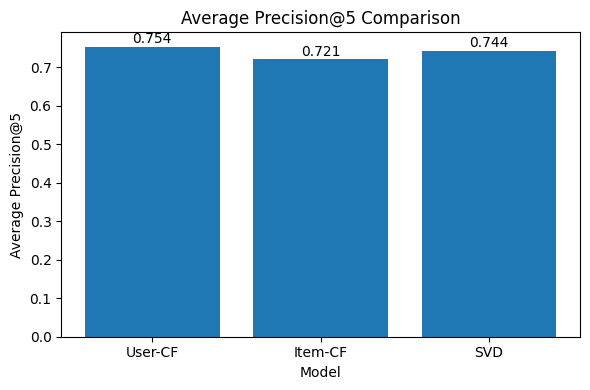

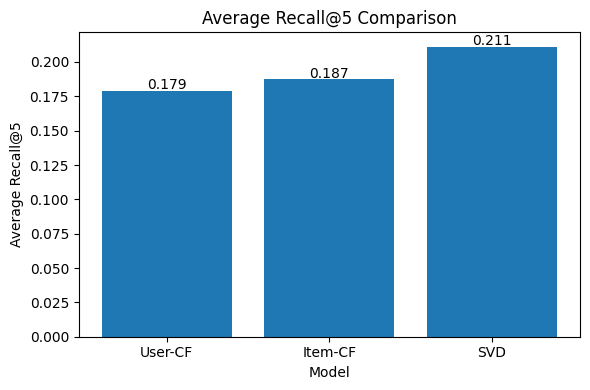

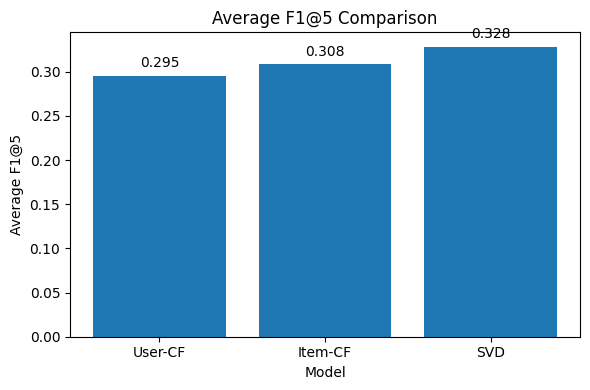

/tmp/ipython-input-2249716264.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


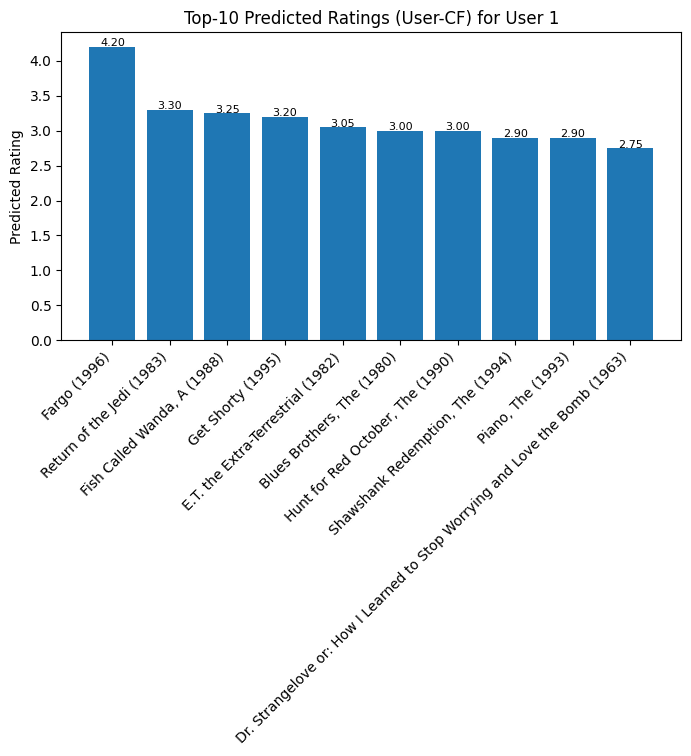

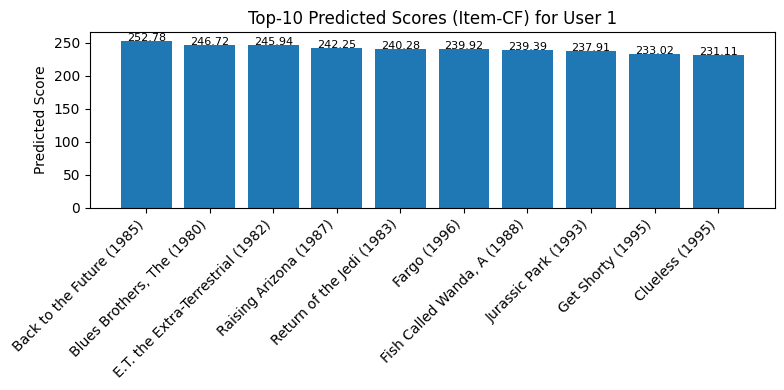

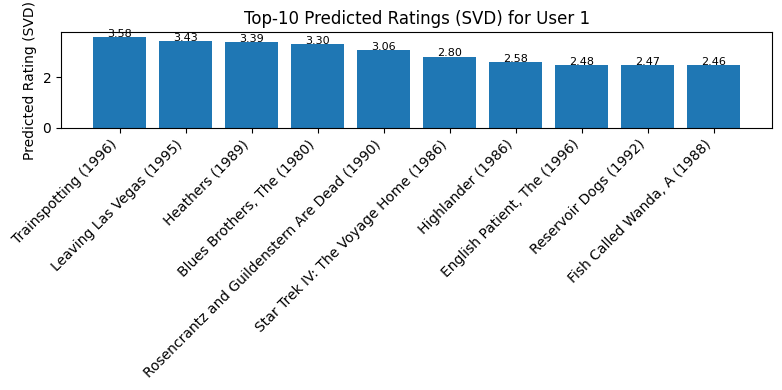

In [53]:
# ---------------------------
# Visualization: Comparison
# ---------------------------
import matplotlib.pyplot as plt

# Reusable evaluation that returns averages (instead of printing)
def evaluate_model_return(recommend_func, k=5):
    precisions, recalls, f1s = [], [], []

    for u in test["user_id"].unique():
        recs = recommend_func(u, top_n=k)
        if recs.empty:
            continue

        actual = test[(test["user_id"] == u) & (test["movie_id"].isin(recs["movie_id"]))]
        if actual.empty:
            continue

        # Precision
        relevant = (actual["rating"] >= 3.5).astype(int)
        recommended_relevant = np.ones(len(actual))
        p = precision_score(relevant, recommended_relevant, zero_division=0)

        # Recall
        all_relevant = test[(test["user_id"] == u) & (test["rating"] >= 3.5)]
        r = (actual["rating"] >= 3.5).sum() / len(all_relevant) if len(all_relevant) > 0 else None

        # F1
        f = 2*(p*r)/(p+r) if (r is not None and (p + r) > 0) else None

        if p is not None: precisions.append(p)
        if r is not None: recalls.append(r)
        if f is not None: f1s.append(f)

    avg_p = np.mean(precisions) if len(precisions) > 0 else 0.0
    avg_r = np.mean(recalls) if len(recalls) > 0 else 0.0
    avg_f = np.mean(f1s) if len(f1s) > 0 else 0.0
    return avg_p, avg_r, avg_f

# Compute average metrics for each model
k = 5  # top-K used for evaluation
usercf_metrics = evaluate_model_return(recommend_movies_train, k=k)
itemcf_metrics = evaluate_model_return(recommend_movies_item, k=k)
svd_metrics    = evaluate_model_return(recommend_movies_svd, k=k)

# Collect for plotting
models = ["User-CF", "Item-CF", "SVD"]
avg_precisions = [usercf_metrics[0], itemcf_metrics[0], svd_metrics[0]]
avg_recalls    = [usercf_metrics[1], itemcf_metrics[1], svd_metrics[1]]
avg_f1s        = [usercf_metrics[2], itemcf_metrics[2], svd_metrics[2]]

# ---------- Plot 1: Average Precision@K ----------
plt.figure(figsize=(6,4))
x = range(len(models))
plt.bar(x, avg_precisions)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average Precision@{k}")
plt.title(f"Average Precision@{k} Comparison")
for i, v in enumerate(avg_precisions):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# ---------- Plot 2: Average Recall@K ----------
plt.figure(figsize=(6,4))
plt.bar(x, avg_recalls)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average Recall@{k}")
plt.title(f"Average Recall@{k} Comparison")
for i, v in enumerate(avg_recalls):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# ---------- Plot 3: Average F1@K ----------
plt.figure(figsize=(6,4))
plt.bar(x, avg_f1s)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average F1@{k}")
plt.title(f"Average F1@{k} Comparison")
for i, v in enumerate(avg_f1s):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# ---------------------------
# Visualization: Top-N predictions for an example user
# ---------------------------
example_user = 1   # change as you like
top_n = 10

# Helper to get Series of movie titles and predicted ratings for plotting
def get_topn_series(recommend_df):
    if recommend_df.empty:
        return pd.Series(dtype=float)
    df = recommend_df.copy()
    df = df.sort_values("Predicted Rating", ascending=False).head(top_n)
    return pd.Series(df["Predicted Rating"].values, index=df["title"].values)

# Get top-N from each model
usercf_top = get_topn_series(recommend_movies_train(example_user, k=20, top_n=top_n))
itemcf_top = get_topn_series(recommend_movies_item(example_user, top_n=top_n))
svd_top    = get_topn_series(recommend_movies_svd(example_user, top_n=top_n))

# Plot User-CF top-N
plt.figure(figsize=(8,4))
if not usercf_top.empty:
    plt.bar(usercf_top.index, usercf_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Rating")
    plt.title(f"Top-{top_n} Predicted Ratings (User-CF) for User {example_user}")
    for i, v in enumerate(usercf_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("User-CF produced no recommendations for this user.")

# Plot Item-CF top-N
plt.figure(figsize=(8,4))
if not itemcf_top.empty:
    plt.bar(itemcf_top.index, itemcf_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Score")
    plt.title(f"Top-{top_n} Predicted Scores (Item-CF) for User {example_user}")
    for i, v in enumerate(itemcf_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Item-CF produced no recommendations for this user.")

# Plot SVD top-N
plt.figure(figsize=(8,4))
if not svd_top.empty:
    plt.bar(svd_top.index, svd_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Rating (SVD)")
    plt.title(f"Top-{top_n} Predicted Ratings (SVD) for User {example_user}")
    for i, v in enumerate(svd_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("SVD produced no recommendations for this user.")


# **Average Precision@K**

This chart compares the average precision@K across three models (User-CF, Item-CF, SVD). Precision measures how many of the recommended movies are actually relevant.

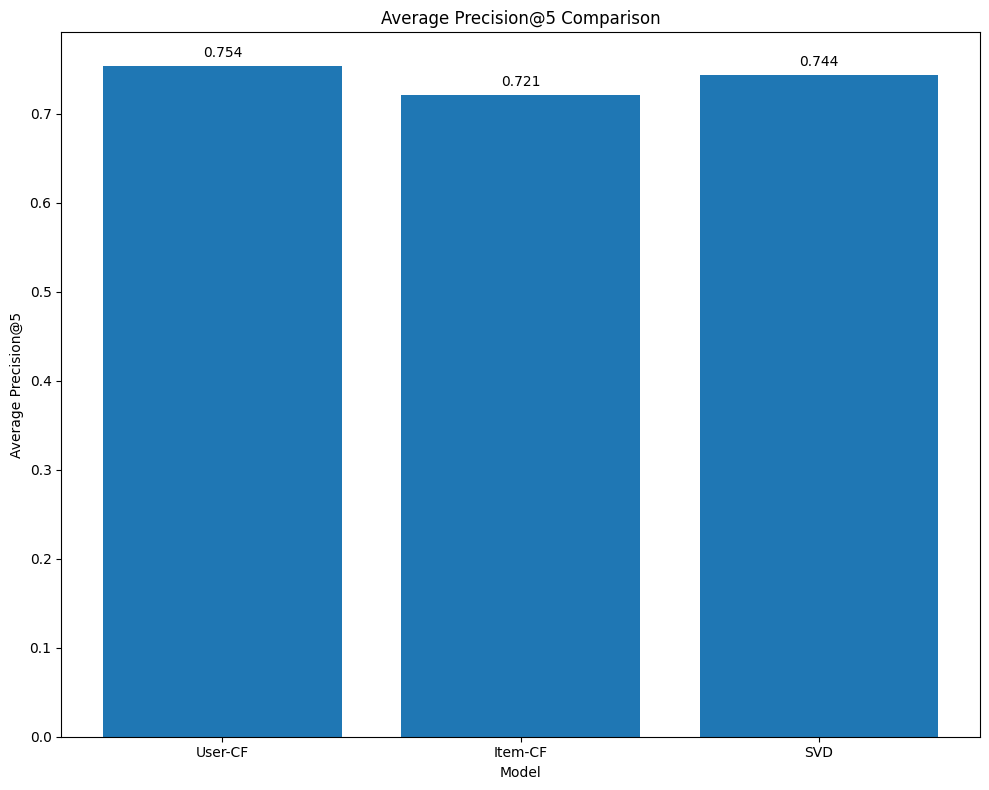

In [66]:
plt.figure(figsize=(10,8))
x = range(len(models))
plt.bar(x, avg_precisions)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average Precision@{k}")
plt.title(f"Average Precision@{k} Comparison")
for i, v in enumerate(avg_precisions):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()


# **Average Recall@K**

This chart compares the average recall@K across models. Recall measures how many of the relevant movies were successfully recommended to users.

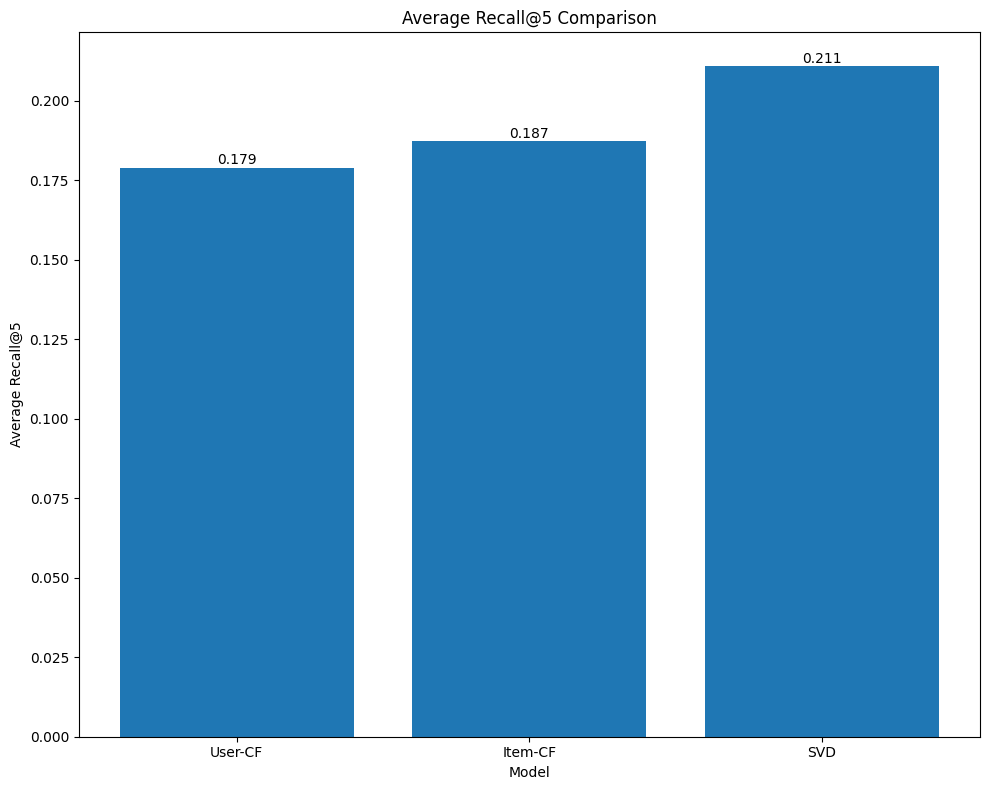

In [65]:
plt.figure(figsize=(10,8))
plt.bar(x, avg_recalls)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average Recall@{k}")
plt.title(f"Average Recall@{k} Comparison")
for i, v in enumerate(avg_recalls):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()


# **Average F1@K**

This chart compares the F1-score@K, which balances precision and recall, showing overall recommendation effectiveness.

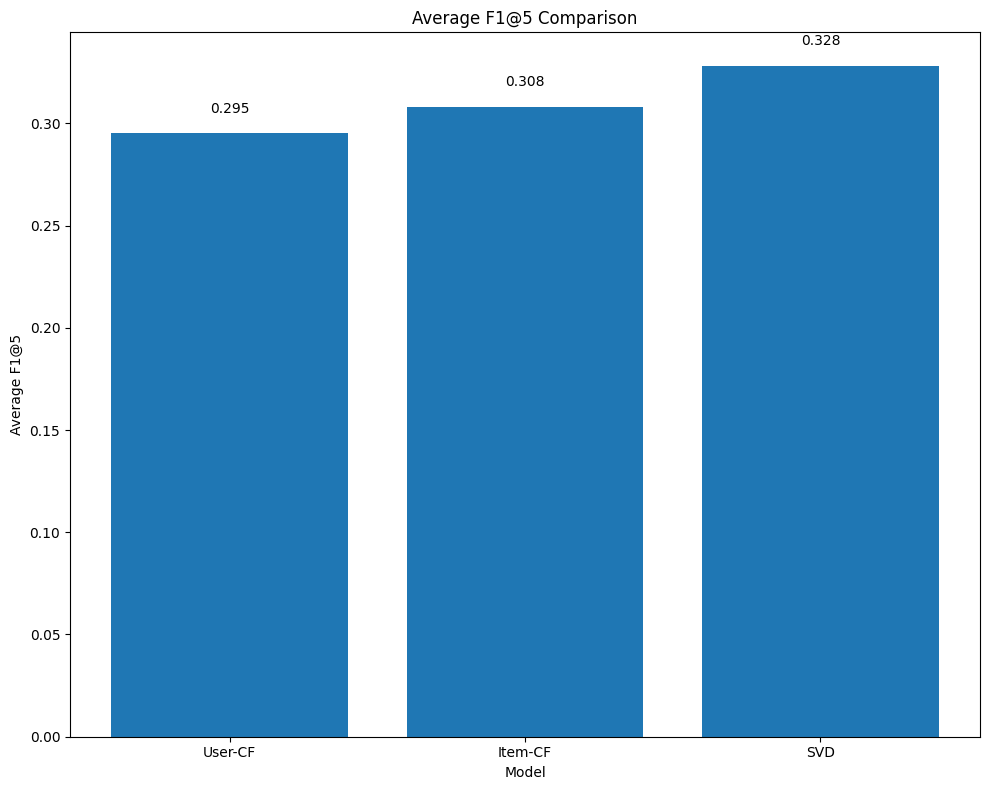

In [64]:
plt.figure(figsize=(10,8))
plt.bar(x, avg_f1s)
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel(f"Average F1@{k}")
plt.title(f"Average F1@{k} Comparison")
for i, v in enumerate(avg_f1s):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()


# **User-CF Top-N Predictions**

Shows the top-N movies recommended for a given user (e.g., User 1) using User-Based Collaborative Filtering. The bar height indicates predicted rating.

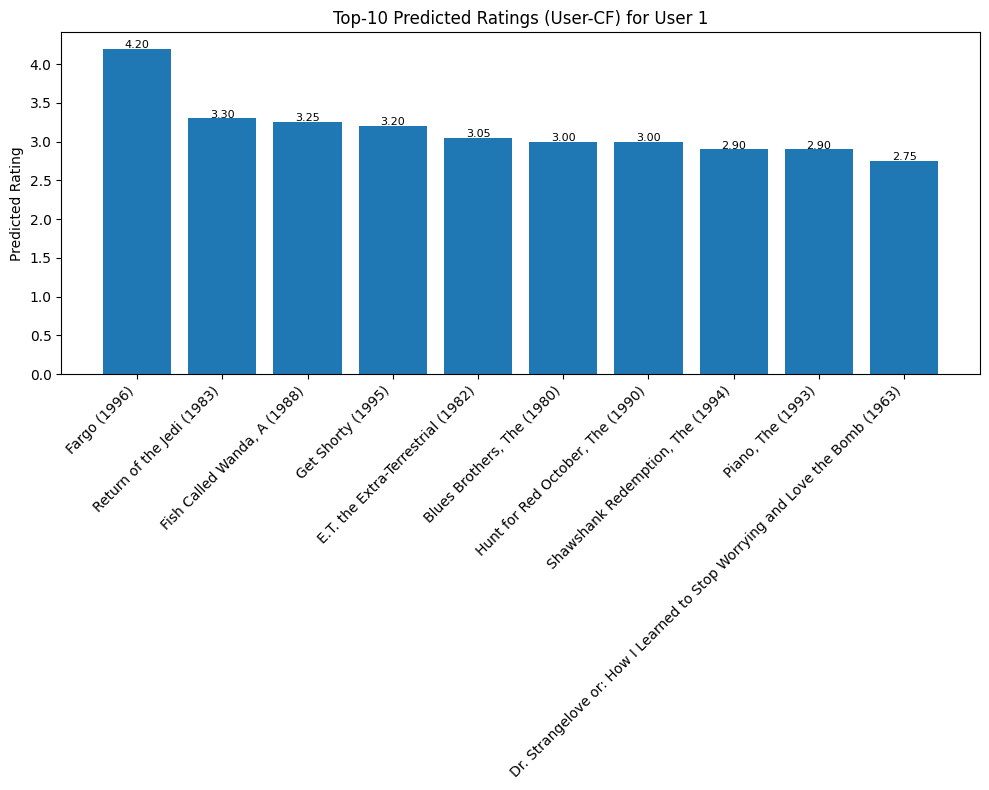

In [61]:
plt.figure(figsize=(10,8))
if not usercf_top.empty:
    plt.bar(usercf_top.index, usercf_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Rating")
    plt.title(f"Top-{top_n} Predicted Ratings (User-CF) for User {example_user}")
    for i, v in enumerate(usercf_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("User-CF produced no recommendations for this user.")


# **Item-CF Top-N Predictions**

Shows the top-N movies recommended for a given user using Item-Based Collaborative Filtering. Bars represent similarity-based predicted scores.

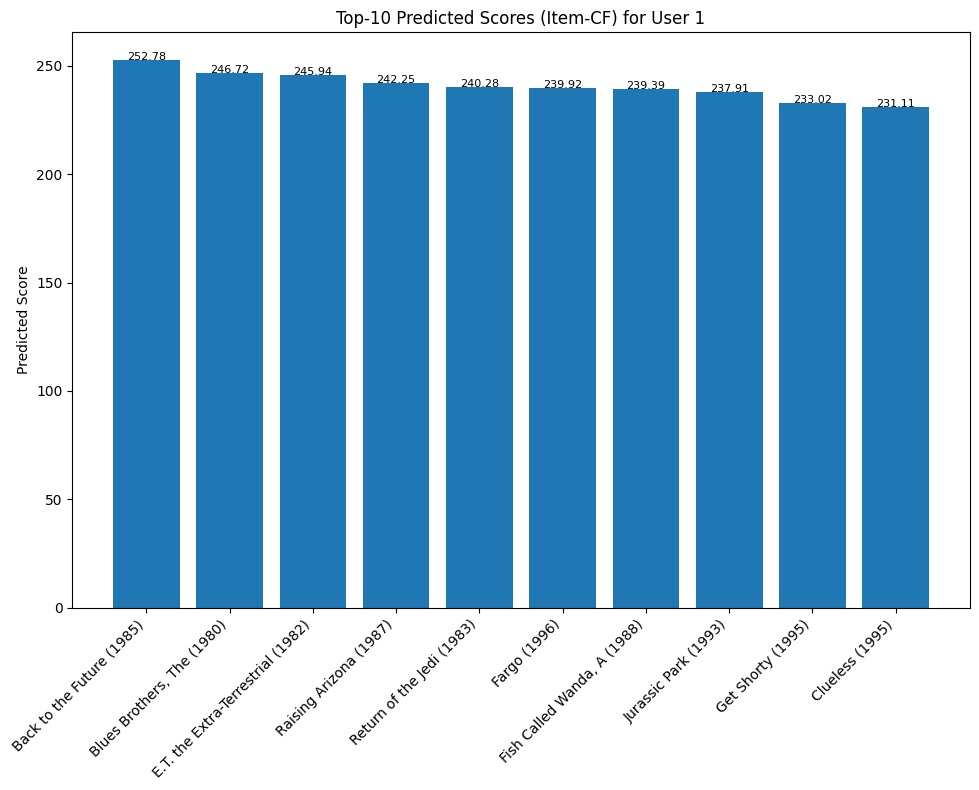

In [62]:
plt.figure(figsize=(10,8))
if not itemcf_top.empty:
    plt.bar(itemcf_top.index, itemcf_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Score")
    plt.title(f"Top-{top_n} Predicted Scores (Item-CF) for User {example_user}")
    for i, v in enumerate(itemcf_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Item-CF produced no recommendations for this user.")


# **SVD Top-N Predictions**

Shows the top-N movies recommended using SVD-based collaborative filtering. Ratings are estimated via latent factor decomposition.

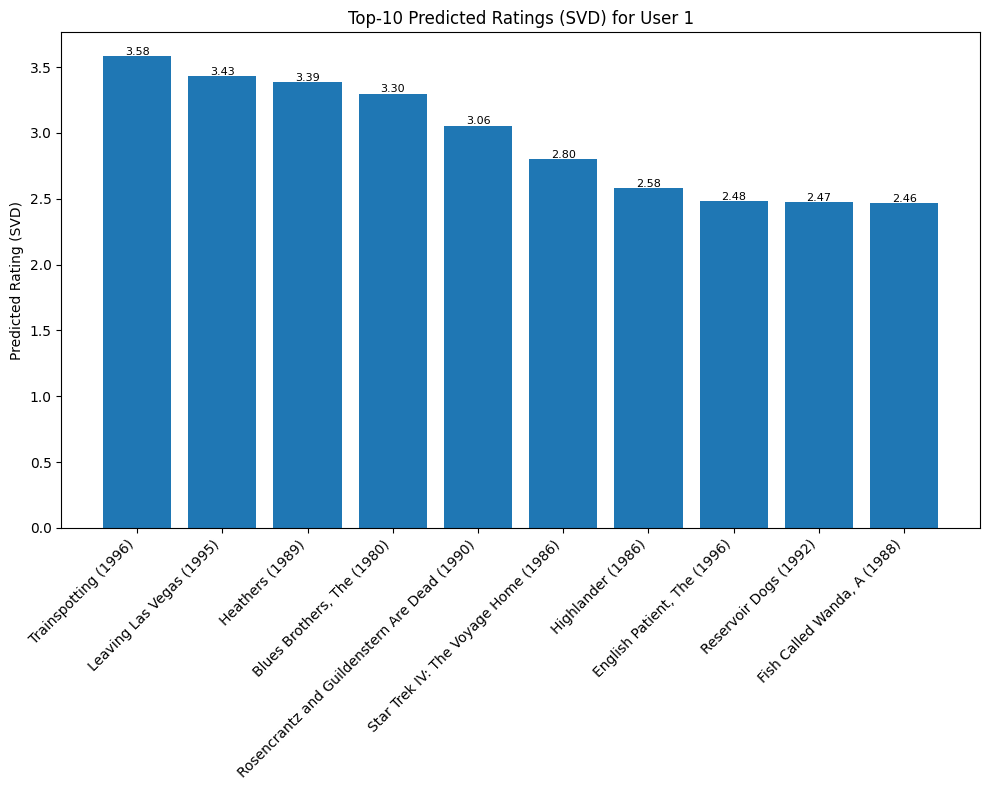

In [63]:
plt.figure(figsize=(10,8))
if not svd_top.empty:
    plt.bar(svd_top.index, svd_top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Predicted Rating (SVD)")
    plt.title(f"Top-{top_n} Predicted Ratings (SVD) for User {example_user}")
    for i, v in enumerate(svd_top.values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("SVD produced no recommendations for this user.")
